# <center> **Data Science Project** 

## <center> **Problem Definition**

### ***Business Understanding***
Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas

### ***In this project, we focused to answer the following questions***
1. Which store has minimum and maximum sales?
2. Which store has maximum standard deviation i.e., the sales vary a lot. Also, find out the coefficient of mean to standard deviation
3. Which store/s has good quarterly growth rate in Q3’2012
4. Some holidays have a negative impact on sales. Find out holidays which have higher sales than the mean sales in non-holiday season for all stores together
5. Provide a monthly and semester view of sales in units and give insights
6. Build prediction to forecast demand.

### ***Data Understanding***
There are sales data available for 45 stores of Walmart in Kaggle. This is the data that covers sales from 2010-02-05 to 2012-10-26.
### ***The data contains these features***
* This file contains anonymized information about the 45 stores, additional data related to the store and regional activity for the given dates. It contains the following fields:
>__Walmark.csv__
* Store - the store number
* Date - the week of sales
* Weekly_Sales - sales for the given department in the given store
* Holiday_Flag - whether the week is a special holiday week (1–Holiday week, 0–Non-holiday week)
* Temperature - average temperature in the region (fahrenheit)
* Fuel_Price - cost of fuel in the region
* CPI – the consumer price index
* Unemployment - the unemployment rate

*For convenience, the four holidays fall within the following weeks in the dataset.<br>(not all holidays are in the data):*
* *Super Bowl : 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13*
* *Labor Day : 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13*
* *Thanksgiving : 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13*
* *Christmas : 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13*

## <center> **Data Acquisition**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import zscore
# Library for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
# Algorithm (Linear Regression)
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [3]:
# Load dataset
missing_sign = ['n/a','na','nan','--','none']
data_set = pd.read_csv('Walmart.csv', na_values=missing_sign)
data_set.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
# Check information of data
data_set.info()

AttributeError: module 'numpy' has no attribute 'iterable'

## <center> **Data Preparation**

In [ ]:
# Convert data type 
data_set['Date'] = pd.to_datetime(data_set['Date'], format='%d-%m-%Y')
data_set[['Store', 'Holiday_Flag']] = data_set[['Store', 'Holiday_Flag']].astype('object')

In [ ]:
# Determine variable type
cat_var = [column for column in data_set.columns if data_set[column].dtype == "object" and data_set[column].nunique() < 46]
num_var = [column for column in data_set.columns if data_set[column].dtype in ['int64', 'float64']]

Column : 'Store'
Unique values : [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]

Column : 'Holiday_Flag'
Unique values : [0 1]



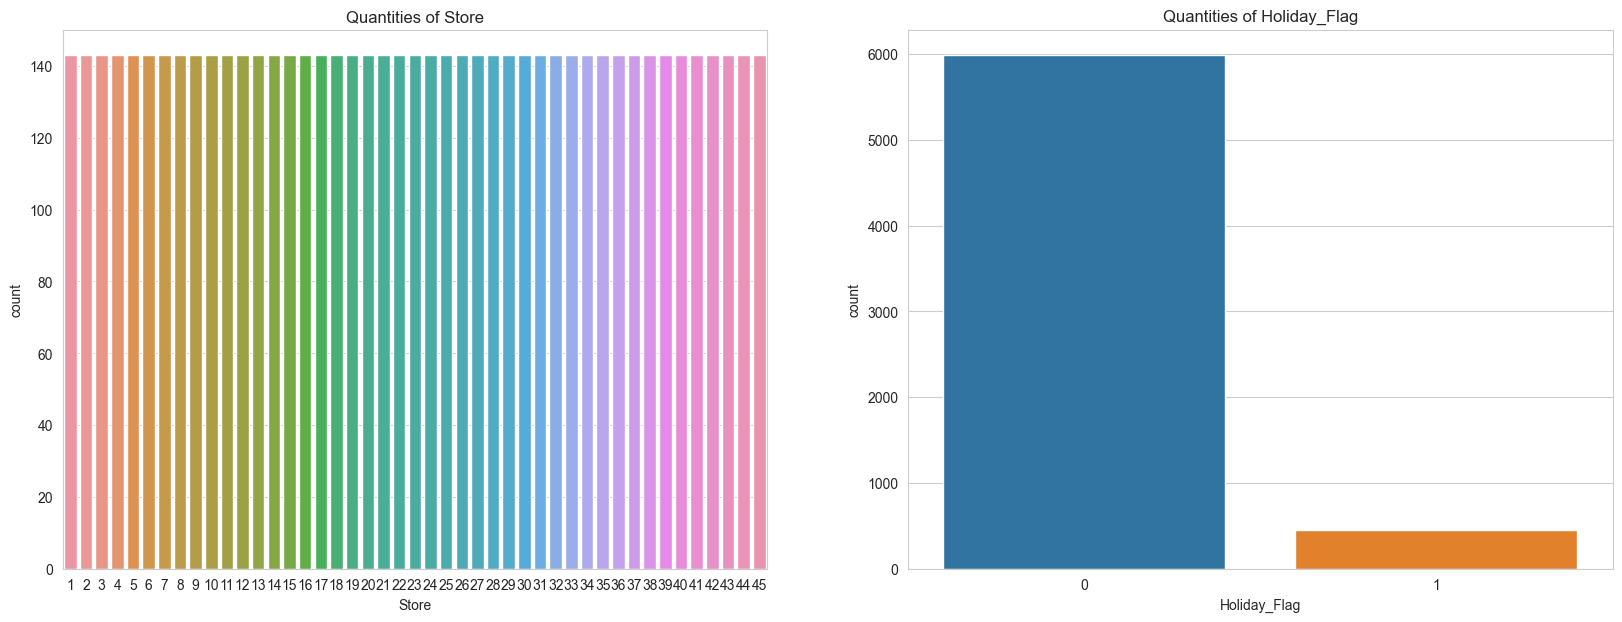

In [ ]:
# Check values each columns (categorical type)
fig, ax = plt.subplots(ncols=len(cat_var), figsize=(20,7))
for idx,column in enumerate(cat_var):
  sns.countplot(data=data_set, x=column, ax=ax[idx]).set_title(f"Quantities of {column}")
  print(f"Column : '{column}'\nUnique values : {data_set[column].unique()}\n")

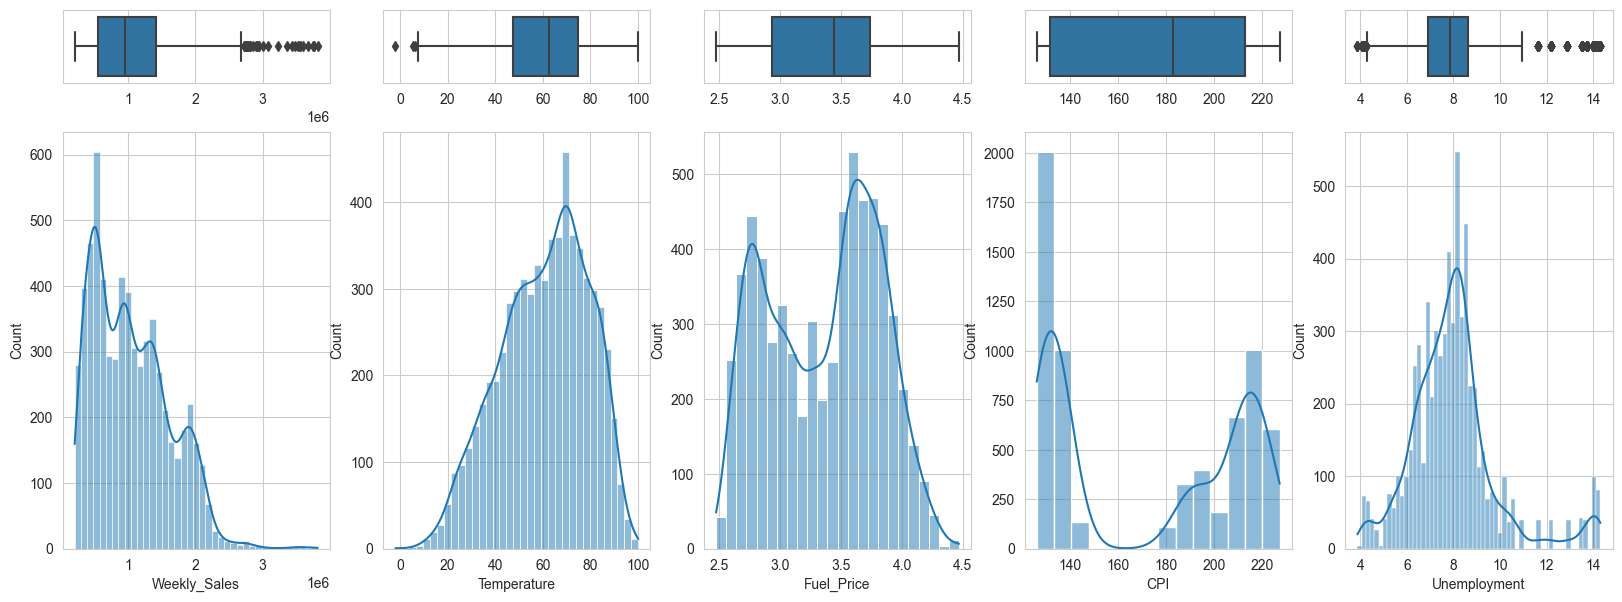

In [ ]:
# Check values each columns (numerical type)
fig, (ax_box, ax_hist) = plt.subplots(ncols=len(num_var), nrows=2, gridspec_kw = {"height_ratios": (.15, .85)}, figsize=(20,7))
for idx,column in enumerate(num_var):
  sns.boxplot(data=data_set, x=column, ax=ax_box[idx])
  sns.histplot(data=data_set, x=column, ax=ax_hist[idx], kde=True)
  ax_box[idx].set(xlabel='')

In [ ]:
data_set.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
# Check statistic of data (numerical type)
data_set.describe()

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,171.578394,7.999151
std,5.643666e+05,18.444933,0.459020,39.356712,1.875885
min,2.099862e+05,-2.060000,2.472000,126.064000,3.879000
25%,5.533501e+05,47.460000,2.933000,131.735000,6.891000
50%,9.607460e+05,62.670000,3.445000,182.616521,7.874000
75%,1.420159e+06,74.940000,3.735000,212.743293,8.622000
max,3.818686e+06,100.140000,4.468000,227.232807,14.313000


### **Data Cleansing**

In [ ]:
df = data_set.copy()

#### *Data Missing*

In [ ]:
# Check missing values
missing_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_count.sum()
percent_missing = total_missing*100/total_cells
print(f"Percentage of missing values : {percent_missing} %")

Percentage of missing values : 0.0 %


#### *Data Outlier*

In [ ]:
# Identifying Outliers with IQR
def cleanOutlier_IQR(data, num_cols):
    count = 1
    while count != 0:
        count = 0
        for column in num_cols: 
            q1 = data[column].quantile(0.25)
            q3 = data[column].quantile(0.75)
            iqr = q3-q1
            upper_whisker = q3+(1.5*iqr)
            lower_whisker = q1-(1.5*iqr)
            idx_out = data.loc[(data[column]>upper_whisker) | (data[column]<lower_whisker)].index
            data.drop(idx_out, inplace=True)
            count += len(idx_out)
    qty_outlier = data_set.shape[0]-data.shape[0]
    percent_outlier = (qty_outlier*100)/data_set.shape[0]
    print(f'Outlier : {qty_outlier} units ({percent_outlier:.2f}%)')
    data.reset_index(drop=True, inplace=True)

In [ ]:
cleanOutlier_IQR(df, num_var)
print(f'Sample before clear outlier : {data_set.shape[0]:,} units')
print(f'Sample after clear outlier : {df.shape[0]:,} units')

Outlier : 596 units (9.26%)
Sample before clear outlier : 6,435 units
Sample after clear outlier : 5,839 units


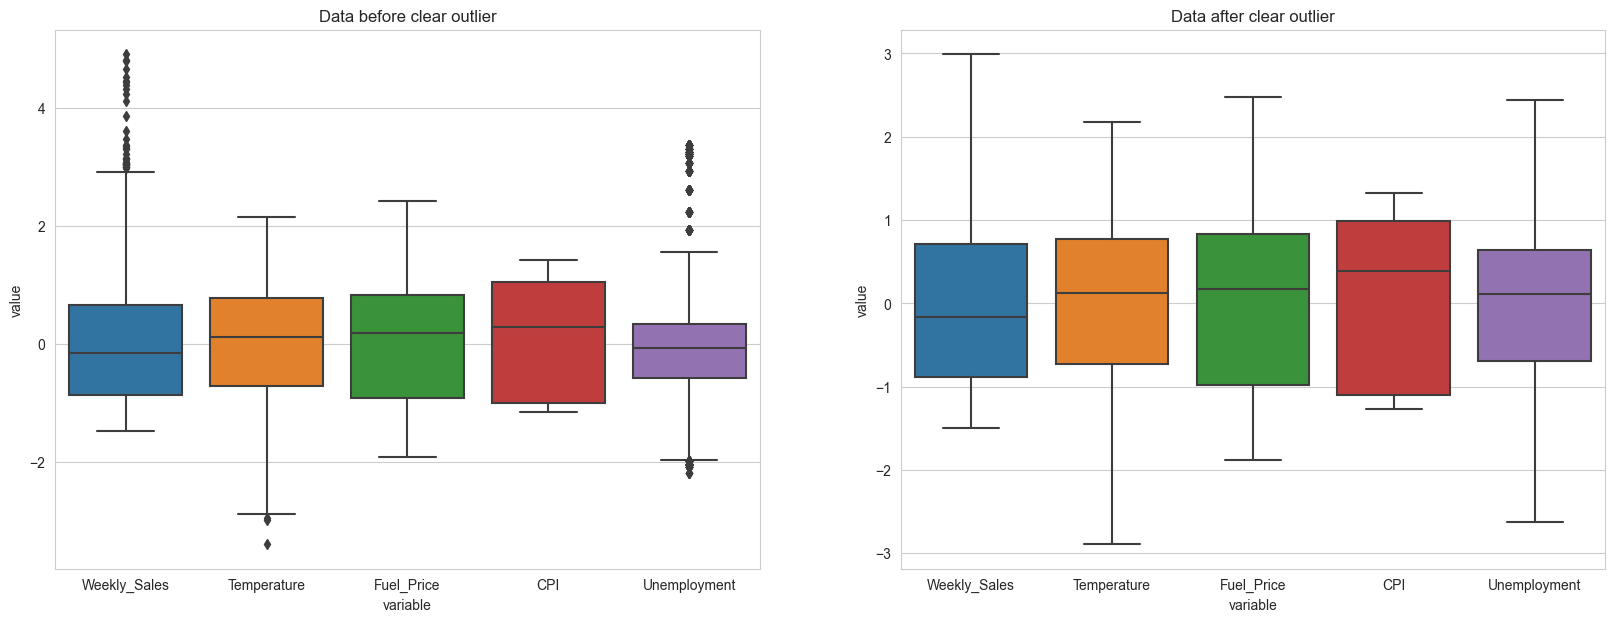

In [ ]:
# Plot distribution of data (numerical variable)
fig, ax = plt.subplots(ncols=2, figsize=(20,7))
sns.boxplot(data=pd.melt(zscore(data_set[num_var])),
            x='variable',
            y='value',
            ax=ax[0]
            ).set_title('Data before clear outlier')
sns.boxplot(data=pd.melt(zscore(df[num_var])),
            x='variable',
            y='value',
            ax=ax[1]
            ).set_title('Data after clear outlier');

#### *Duplicate Data*

In [ ]:
# Check duplicate data
def cleanDuplicated(data):
    count_duplicated = data.duplicated().sum()
    print(f"Duplicated : {count_duplicated} ea.")
    if count_duplicated != 0:
        data.drop_duplicates(inplace=True)
        print('Clean duplicate data complete!')

In [ ]:
cleanDuplicated(df)

Duplicated : 0 ea.


## <center> **Exploratory data analysis**

### **Question 1:** *Which store has minimum and maximum sales?*

In [ ]:
# Total weekly sales for each store
total_sales = data_set.groupby('Store')['Weekly_Sales'].sum()
print(f'Store {total_sales.idxmax()} has maximum sales : {total_sales.max():,.2f} USD')
print(f'Store {total_sales.idxmin()} has minimum sales : {total_sales.min():,.2f} USD')

Store 20 has maximum sales : 301,397,792.46 USD
Store 33 has minimum sales : 37,160,221.96 USD


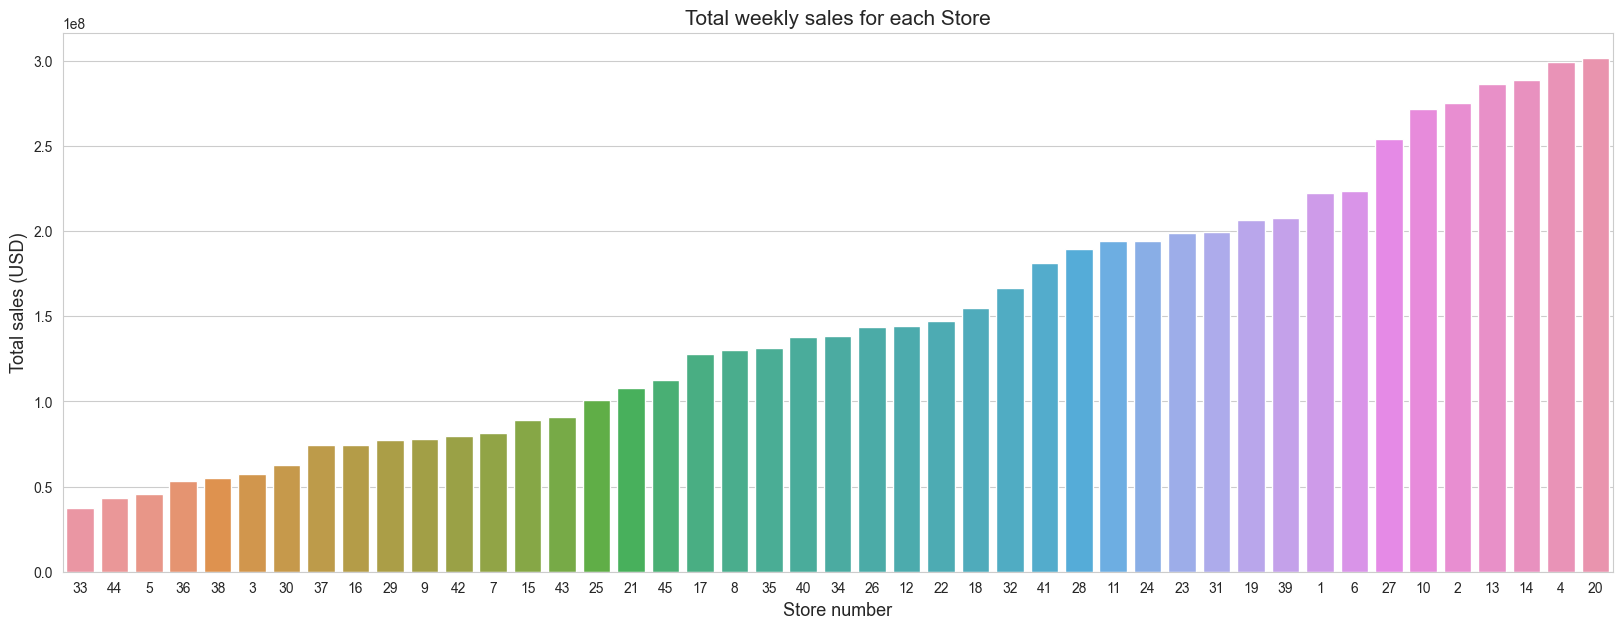

In [ ]:
# Plot properties (total sales)
# Configure the graph display 
plt.figure(figsize=(20,7))
ax = sns.barplot(x=total_sales.index,
                 y=total_sales.values,
                 order=total_sales.sort_values().index
                 )
# Configure the title text
ax.set_title("Total weekly sales for each Store", fontsize=15)
ax.set_xlabel("Store number", fontsize=13)
ax.set_ylabel("Total sales (USD)", fontsize=13);

### **Question 2:** *Which store has maximum standard deviation i.e., the sales vary a lot. Also, find out the coefficient of mean to standard deviation*

In [ ]:
# Combining statistics results in weekly sales for each store. (standard deviation and mean)
sales_stats = data_set.groupby('Store').agg({'Weekly_Sales':['std','mean']})
sales_stats['Coefficient'] = sales_stats['Weekly_Sales']['std']/sales_stats['Weekly_Sales']['mean']
sales_stats.sort_values(('Weekly_Sales','std'), ascending=False).head()

Weekly_Sales               Coefficient
                 std          mean            
Store                                         
14     317569.949476  2.020978e+06    0.157137
10     302262.062504  1.899425e+06    0.159133
20     275900.562742  2.107677e+06    0.130903
4      266201.442297  2.094713e+06    0.127083
13     265506.995776  2.003620e+06    0.132514

In [ ]:
# The highest standard deviation of sales
max_std = sales_stats['Weekly_Sales']['std'].max()
idx_max_std = sales_stats['Weekly_Sales']['std'].idxmax()
print(f"Store {idx_max_std} has the highest standard deviation of sales : {max_std:,.2f}")
print(f"Coefficient of mean to standard deviation : {sales_stats['Coefficient'].loc[idx_max_std]:.2f}")

Store 14 has the highest standard deviation of sales : 317,569.95
Coefficient of mean to standard deviation : 0.16


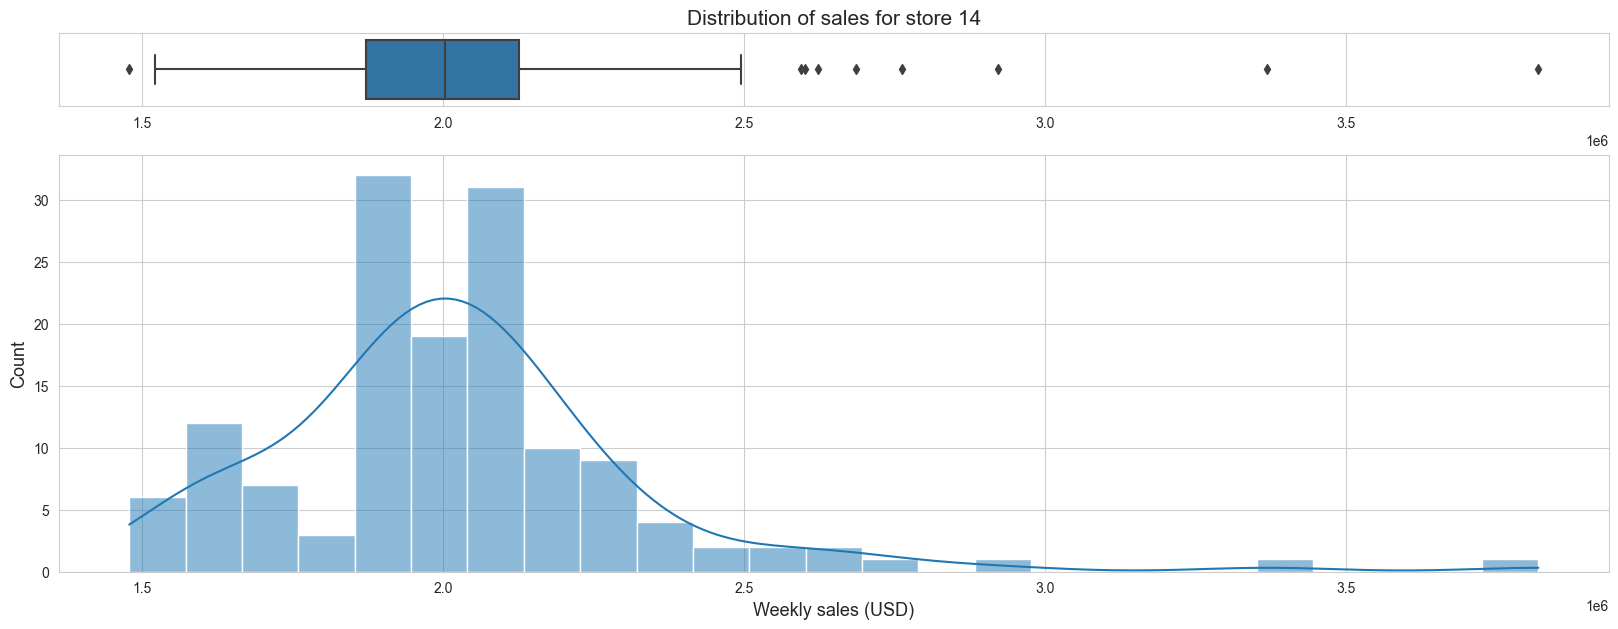

In [ ]:
# Plot properties (distribution of sales)
data_plot = data_set.loc[data_set['Store']==idx_max_std, ['Weekly_Sales']]
# Configure the graph display 
fig, (ax_box, ax_hist) = plt.subplots(nrows=2, gridspec_kw = {"height_ratios": (.15, .85)}, figsize=(20,7))
sns.boxplot(data=data_plot, x='Weekly_Sales', ax=ax_box)
sns.histplot(data=data_plot, x='Weekly_Sales', kde=True, ax=ax_hist)
ax_box.set(xlabel='')
# Configure the title text
ax_box.set_title(f"Distribution of sales for store {idx_max_std}", fontsize=15)
ax_hist.set_xlabel("Weekly sales (USD)", fontsize=13)
ax_hist.set_ylabel("Count", fontsize=13);

### **Question 3:** *Which store/s has good quarterly growth rate in Q3’2012*

In [ ]:
col_use = ['Store','Date','Weekly_Sales']
df_growth = data_set[col_use].copy()
# Create new columns 'Year' and 'Quarter'
df_growth['Year'] = df_growth['Date'].dt.year
df_growth['Quarter'] = df_growth['Date'].dt.quarter

In [ ]:
# Only data for the year 2012 was filtered
# Quanter 2
quarter_2 = df_growth.loc[(df_growth['Year']==2012)&(df_growth['Quarter']==2)]
sales_Q2 = quarter_2.groupby('Store').agg({'Weekly_Sales':sum}).rename(columns={'Weekly_Sales':'Total_Sales_Q2'})
# Quarter 3
quarter_3 = df_growth.loc[(df_growth['Year']==2012)&(df_growth['Quarter']==3)]
sales_Q3 = quarter_3.groupby('Store').agg({'Weekly_Sales':sum}).rename(columns={'Weekly_Sales':'Total_Sales_Q3'})

In [ ]:
# Combining data from quarters 2 and 3
growth_rate = sales_Q2.merge(sales_Q3, on='Store')
growth_rate['Growth_Rate'] = (growth_rate['Total_Sales_Q3']-growth_rate['Total_Sales_Q2'])*100/growth_rate['Total_Sales_Q2']
growth_rate.sort_values('Growth_Rate', ascending=False).head()

,Total_Sales_Q2,Total_Sales_Q3,Growth_Rate
Store,,,
7,7290859.27,8262787.39,13.330776
16,6564335.98,7121541.64,8.488378
35,10838313.00,11322421.12,4.466637
26,13155335.57,13675691.91,3.955478
39,20214128.46,20715116.23,2.478404


In [ ]:
# The highest and the lowest growth rates in Q3 2012
print(f"Store {growth_rate['Growth_Rate'].idxmax()} has the highest growth rate of {growth_rate['Growth_Rate'].max():.2f}%.")
print(f"Store {growth_rate['Growth_Rate'].idxmin()} has the lowest growth rate of {growth_rate['Growth_Rate'].min():.2f}%.")

Store 7 has the highest growth rate of 13.33%.
Store 14 has the lowest growth rate of -15.77%.


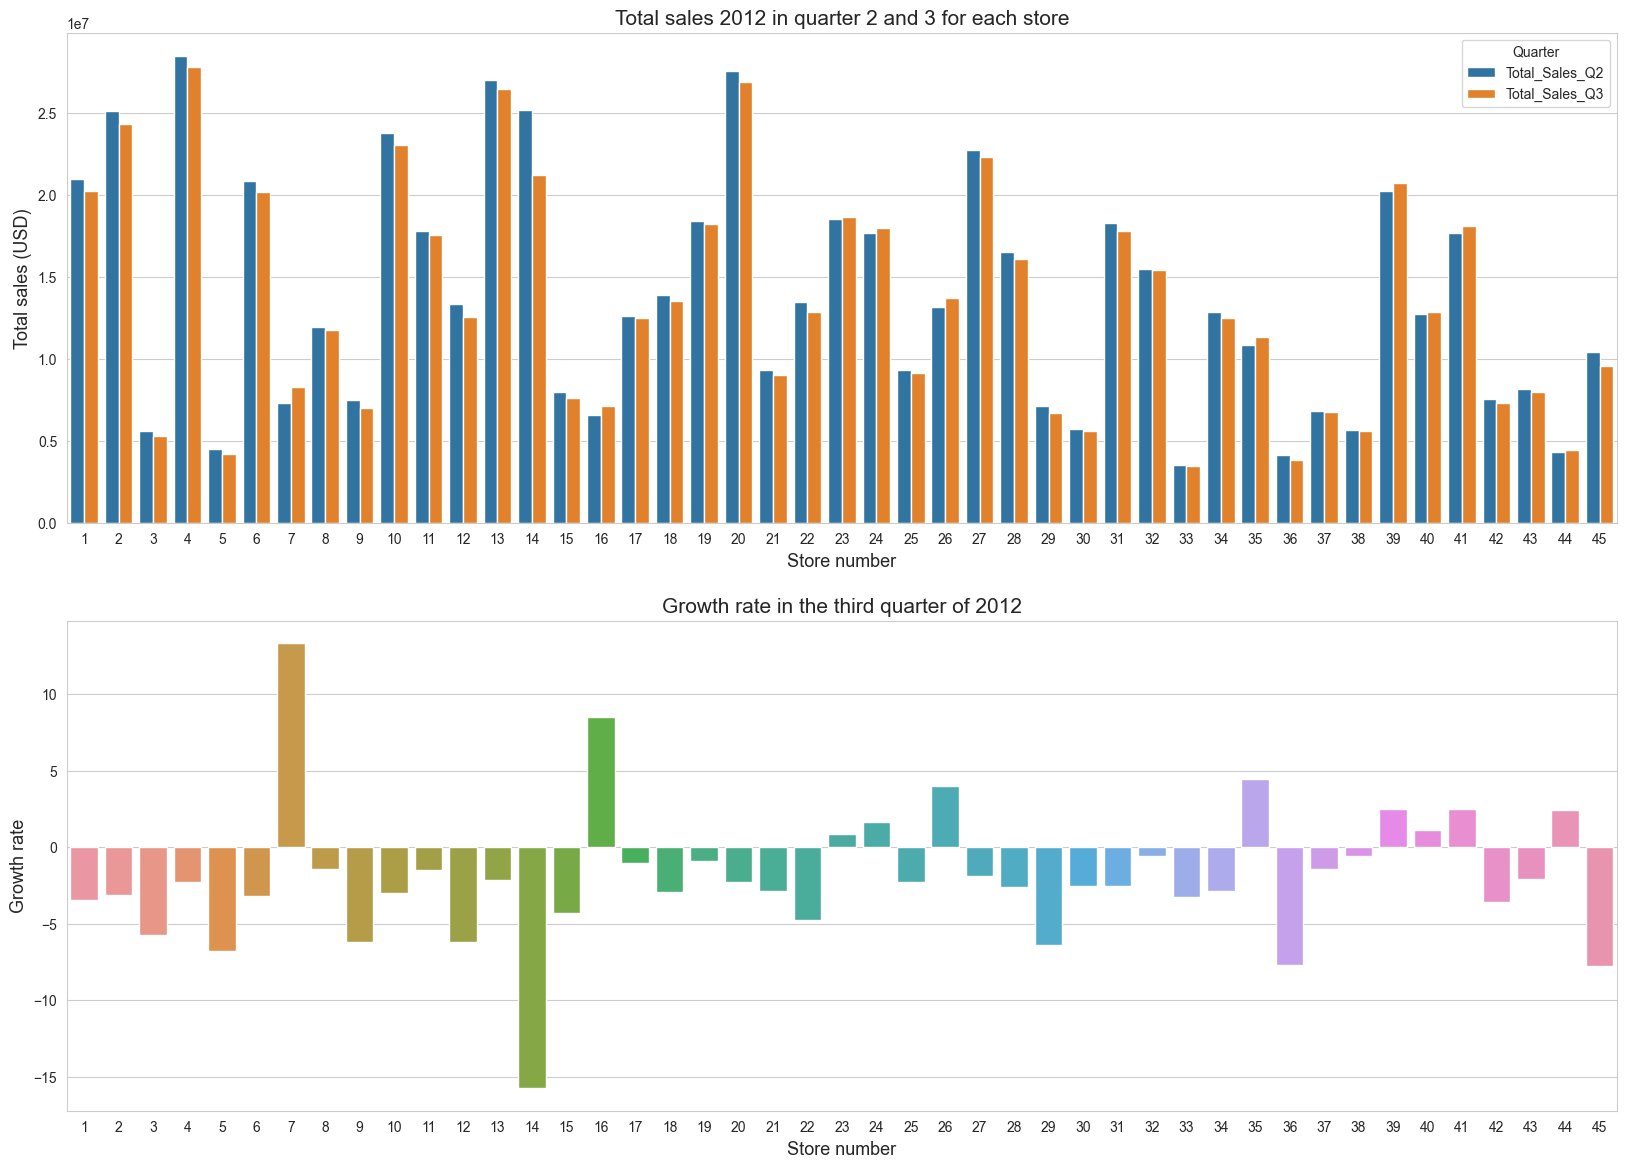

In [ ]:
# Plot properties (total sales and growth rate 2012 in quarter 2 and 3 for each store)
# Configure the graph display and title text
# Total sales
df_plot = pd.melt(growth_rate.drop('Growth_Rate',axis=1), ignore_index=False)
fig, ax = plt.subplots(nrows=2, figsize=(20,14))
sns.barplot(x=df_plot.index,
            y=df_plot['value'],
            hue=df_plot['variable'],
            ax=ax[0]
            ).set_title("Total sales 2012 in quarter 2 and 3 for each store", fontsize=15)
ax[0].set_xlabel("Store number", fontsize=13)
ax[0].set_ylabel("Total sales (USD)", fontsize=13)
ax[0].legend(title='Quarter', fontsize=10)
# Growth rate
sns.barplot(x=growth_rate.index,
            y=growth_rate['Growth_Rate'],
            ax=ax[1]
            ).set_title("Growth rate in the third quarter of 2012", fontsize=15)
ax[1].set_xlabel("Store number", fontsize=13)
ax[1].set_ylabel("Growth rate", fontsize=13);

### **Question 4:** *Some holidays have a negative impact on sales. Find out holidays which have higher sales than the mean sales in non-holiday season for all stores together*
* Super Bowl : 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
* Labor Day : 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
* Thanksgiving : 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
* Christmas : 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [ ]:
col_use = ['Date','Weekly_Sales','Holiday_Flag']
df_holiday = data_set.loc[data_set['Holiday_Flag']==1, col_use].copy()
holiday_list = {
    'Super Bowl Date' : pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10']),
    'Labor Day' : pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07']),
    'Thanksgiving' : pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23']),
    'Christmas' : pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28'])
}
# Create new columns 'Holiday'
for i in holiday_list:
  df_holiday.loc[df_holiday['Date'].isin(holiday_list[i]), 'Holiday'] = i

In [ ]:
# Mean sales for each holiday
# Holiday
mean_sales_holiday = df_holiday.groupby('Holiday')['Weekly_Sales'].mean().to_frame(name='Mean_Sales')
# Non-Holiday
non_holiday = {
    'Mean_Sales': data_set.loc[data_set['Holiday_Flag']==0, 'Weekly_Sales'].mean()
}
df_non_holiday = pd.DataFrame([non_holiday],index=['Normal Day'])
# Combining data from mean sales in holiday and non-holiday
mean_sales = pd.concat([mean_sales_holiday,df_non_holiday], axis=0)
mean_sales

,Mean_Sales
Christmas,9.608331e+05
Labor Day,1.042427e+06
Super Bowl Date,1.079128e+06
Thanksgiving,1.471273e+06
Normal Day,1.041256e+06


In [ ]:
# The highest mean sales
print(f"'{mean_sales['Mean_Sales'].idxmax()}' holiday has higher sales than another events : {mean_sales['Mean_Sales'].max():,.2f} USD")

'Thanksgiving' holiday has higher sales than another events : 1,471,273.43 USD


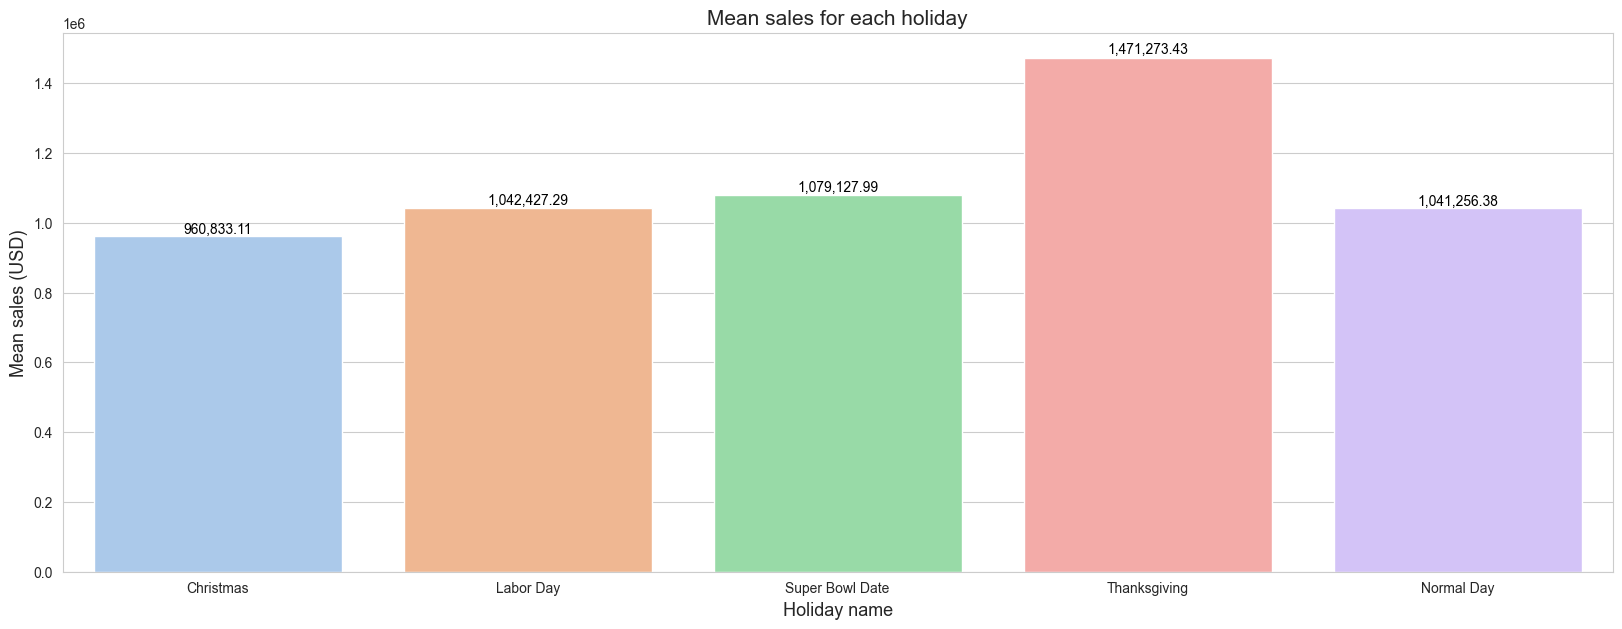

In [ ]:
# Plot properties (Mean sales for each store)
# Configure the graph display
plt.figure(figsize=(20,7))
ax = sns.barplot(x=mean_sales.index, 
                 y=mean_sales['Mean_Sales'], 
                 palette='pastel'
                 )
# Configure the title text
for index, row in mean_sales.reset_index().iterrows():
  ax.text(index, row['Mean_Sales']*1.01, '{:,.2f}'.format(row['Mean_Sales']), ha='center', color='black')
ax.set_title(f"Mean sales for each holiday", fontsize=15)
ax.set_xlabel("Holiday name", fontsize=13)
ax.set_ylabel("Mean sales (USD)", fontsize=13);

### **Question 5:** *Provide a monthly and semester view of sales in units and give insights*

In [ ]:
col_use = ['Weekly_Sales','Date']
df_sum = df[col_use].copy()
# Create new column 'Month','Year' and 'Semester'
df_sum['Month'] = df_sum['Date'].dt.month
df_sum['Year'] = df_sum['Date'].dt.year
year = df_sum['Year'].unique()
Semester = {
    'Semester_1' : np.arange(1,7),
    'Semester_2' : np.arange(6,13)
    }
for idy,y in enumerate(year):
    for ids,s in enumerate(Semester):
        df_sum.loc[(df_sum['Month'].isin(Semester[s]))&(df_sum['Year']==y), 'Semester'] = ids+1+(idy*2)

In [ ]:
df_sum.head()

,Weekly_Sales,Date,Month,Year,Semester
0,1643690.90,2010-02-05,2,2010,1.0
1,1641957.44,2010-02-12,2,2010,1.0
2,1611968.17,2010-02-19,2,2010,1.0
3,1409727.59,2010-02-26,2,2010,1.0
4,1554806.68,2010-03-05,3,2010,1.0


In [ ]:
# Total monthly sales for each year
monthly_sales = df_sum.pivot_table(index='Month', values='Weekly_Sales', columns='Year', aggfunc='sum', fill_value=0, margins=True)
monthly_sales

Year,2010,2011,2012,All
Month,,,,
1,0.000000e+00,1.522562e+08,1.510462e+08,3.033024e+08
2,1.783441e+08,1.741784e+08,1.706385e+08,5.231610e+08
3,1.710599e+08,1.682535e+08,2.061064e+08,5.454199e+08
4,2.182086e+08,2.131651e+08,1.597913e+08,5.911649e+08
5,1.762177e+08,1.711692e+08,1.597430e+08,5.071299e+08
6,1.814865e+08,1.791118e+08,2.035853e+08,5.641836e+08
7,2.199126e+08,2.171255e+08,1.587053e+08,5.957435e+08
8,1.772900e+08,1.780078e+08,1.999168e+08,5.552146e+08
9,1.671630e+08,2.080930e+08,1.528497e+08,5.281057e+08


In [ ]:
month = {
     1 : 'January',
     2 : 'February',
     3 : 'March',
     4 : 'April',
     5 : 'May',
     6 : 'June',
     7 : 'July',
     8 : 'August',
     9 : 'September',
    10 : 'October',
    11 : 'November',
    12 : 'December'
    }

In [ ]:
print(f"The highest annual sales (2010-2012) were {monthly_sales.loc['All'][:-1].max():,.2f} USD in {monthly_sales.loc['All'][:-1].idxmax()}.")
print(f"The highest total monthly sales for 3 years (2010-2012) were {monthly_sales['All'][:-1].max():,.2f} USD in {month[monthly_sales['All'][:-1].idxmax()]}.\n")
for i in year:
  print(f'----------------------- Year : {i} -----------------------')
  print(f"The highest sales in {i} were {monthly_sales[i][:-1].max():,.2f} USD in {month[monthly_sales[i][:-1].idxmax()]}.")
  print(f"The lowest sales in {i} were {monthly_sales[i][:-1].min():,.2f} USD in {month[monthly_sales[i][:-1].idxmin()]}.\n")

The highest annual sales (2010-2012) were 2,225,224,071.64 USD in 2011.
The highest total monthly sales for 3 years (2010-2012) were 595,743,462.88 USD in July.

----------------------- Year : 2010 -----------------------
The highest sales in 2010 were 226,266,418.96 USD in December.
The lowest sales in 2010 were 0.00 USD in January.

----------------------- Year : 2011 -----------------------
The highest sales in 2011 were 225,249,598.74 USD in December.
The lowest sales in 2011 were 152,256,207.50 USD in January.

----------------------- Year : 2012 -----------------------
The highest sales in 2012 were 206,106,414.81 USD in March.
The lowest sales in 2012 were 0.00 USD in November.



In [ ]:
# Total sales per semester
semester_sales = df_sum.pivot_table(index='Semester', values='Weekly_Sales', aggfunc='sum', margins=True)
semester_sales

,Weekly_Sales
Semester,
1.0,7.438303e+08
2.0,1.353999e+09
3.0,8.790224e+08
4.0,1.346202e+09
5.0,8.473253e+08
6.0,8.813498e+08
All,6.051729e+09


In [ ]:
print(f"The highest sales in the semester were {semester_sales['Weekly_Sales'][:-1].max():,.2f} USD in semester {int(semester_sales['Weekly_Sales'][:-1].idxmax())}")
print(f"The lowest sales in the semester were {semester_sales['Weekly_Sales'][:-1].min():,.2f} USD in semester {int(semester_sales['Weekly_Sales'][:-1].idxmin())}")

The highest sales in the semester were 1,353,999,139.36 USD in semester 2
The lowest sales in the semester were 743,830,280.45 USD in semester 1


C:\Users\summe\AppData\Local\Temp\ipykernel_4968\3180797398.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sum,


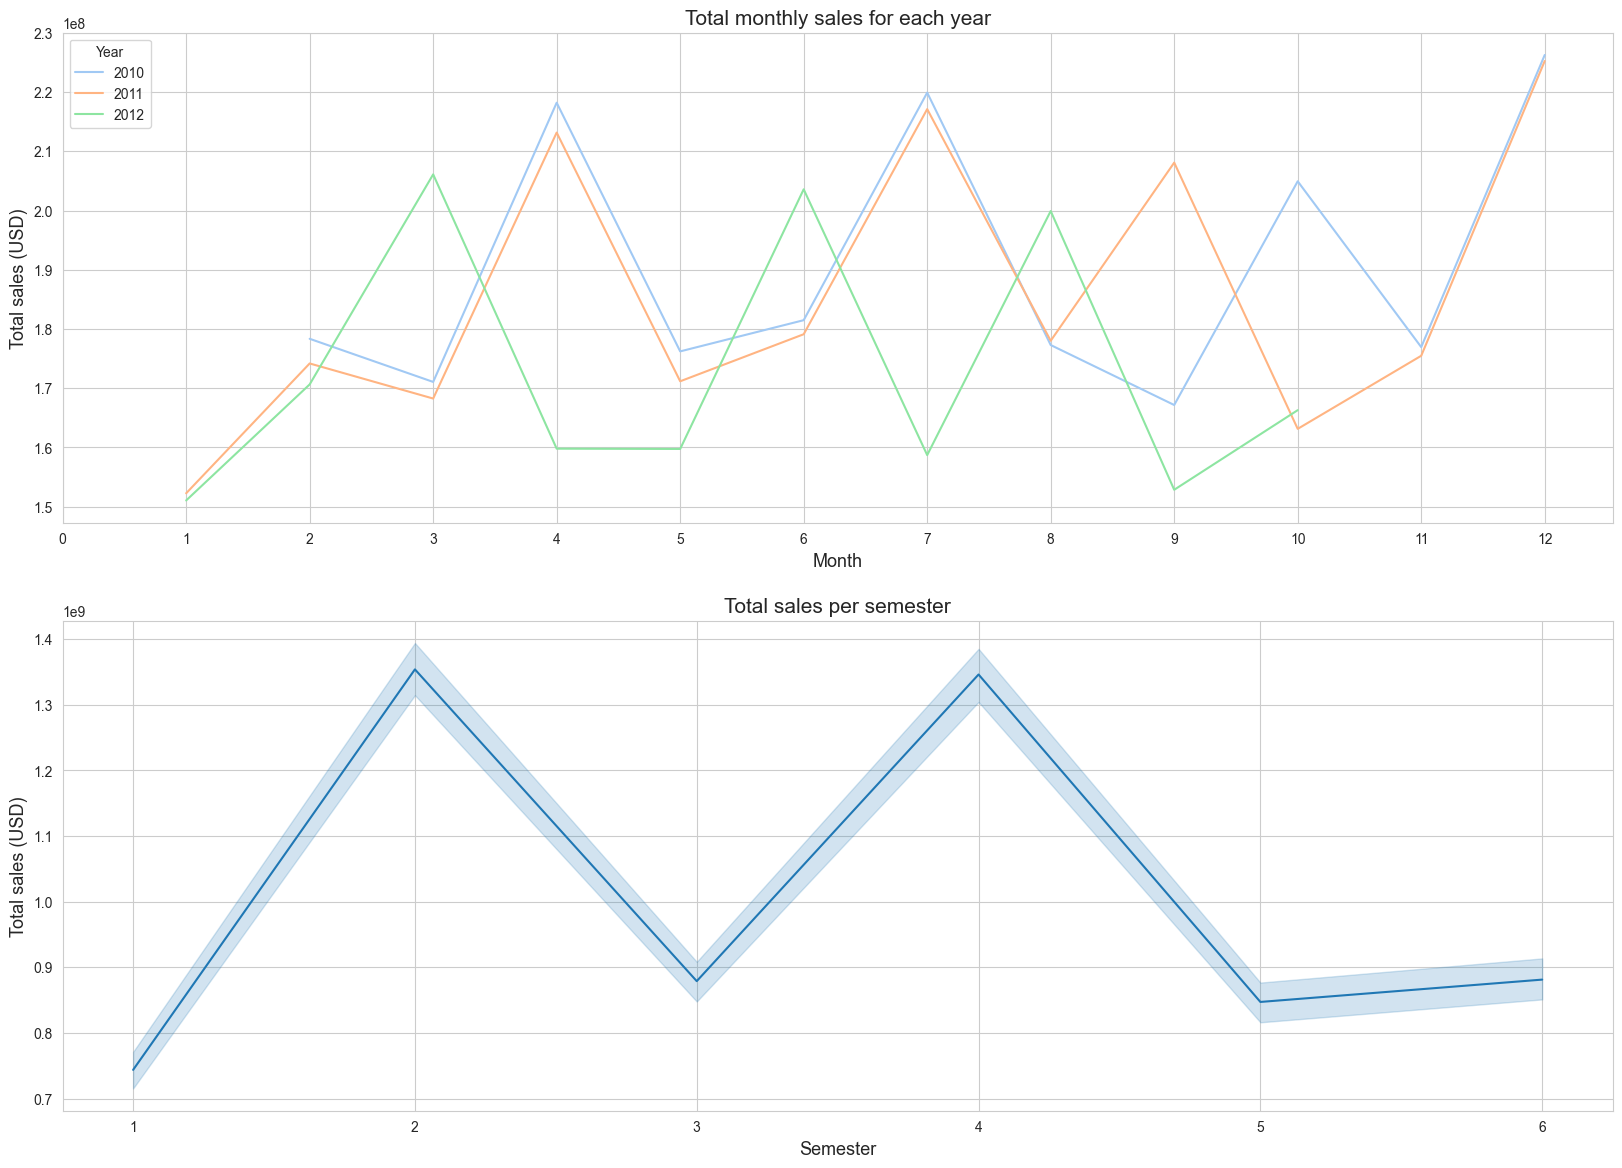

In [ ]:
# Plot properties 
# Configure the graph display (total monthly sales)
fig, ax = plt.subplots(nrows=2, figsize = (20,14))
sns.lineplot(data=df_sum,
             x='Month',
             y='Weekly_Sales',
             hue='Year',
             estimator=np.sum,
             palette='pastel',
             errorbar=None,
             ax=ax[0]
             ).set_title('Total monthly sales for each year', fontsize=15)
ax[0].set_xlabel("Month", fontsize=13)
ax[0].set_xticks(range(13), labels=range(0, 13))
ax[0].set_ylabel("Total sales (USD)", fontsize=13)
ax[0].legend(title='Year', fontsize=10)
# Configure the graph display (total sales per semester)
sns.lineplot(data=df_sum,
             x='Semester',
             y='Weekly_Sales',
             estimator =np.sum,
             ax=ax[1]
             ).set_title('Total sales per semester', fontsize=15)
ax[1].set_xlabel("Semester", fontsize=13)
ax[1].set_ylabel("Total sales (USD)", fontsize=13);

## <center> **Modelling**

### **Question 6:** *Build prediction to forecast demand*

#### **Prepare data**

In [ ]:
# Use the data after "Data Cleaning"
df_sales = df.copy()

#### *Feature Engineering*

In [ ]:
# Create new columns "Year", "Month" and "Holiday"
df_sales['Month'] = df_sales['Date'].dt.month.astype(object)
df_sales['Year'] = df_sales['Date'].dt.year.astype(object)
for event,date in holiday_list.items():
    df_sales.loc[df_sales['Date'].isin(date), 'Holiday'] = event
df_sales['Holiday'].fillna(value='Non-Holiday', inplace=True)
df_sales.drop(columns=['Holiday_Flag'], inplace=True)
df_sales.set_index('Date', inplace=True)

In [ ]:
# Group temperature
bins = [0, 50, 77, 86, 104]
labels = [1, 2, 3, 4]
df_sales['Temp'] = pd.cut(df_sales['Temperature'], bins=bins, labels=labels, include_lowest=True).astype('object')
df_sales.drop('Temperature', axis=1, inplace=True)

In [ ]:
df_sales.head()

,Store,Weekly_Sales,Fuel_Price,CPI,Unemployment,Month,Year,Holiday,Temp
Date,,,,,,,,,
2010-02-05,1,1643690.90,2.572,211.096358,8.106,2,2010,Non-Holiday,1
2010-02-12,1,1641957.44,2.548,211.242170,8.106,2,2010,Super Bowl Date,1
2010-02-19,1,1611968.17,2.514,211.289143,8.106,2,2010,Non-Holiday,1
2010-02-26,1,1409727.59,2.561,211.319643,8.106,2,2010,Non-Holiday,1
2010-03-05,1,1554806.68,2.625,211.350143,8.106,3,2010,Non-Holiday,1


In [ ]:
# Determine the category variable.
cat_var = [col for col in df_sales.columns if df_sales[col].dtypes=="object"]
print(f"Categorical columns : {cat_var}")

Categorical columns : ['Store', 'Month', 'Year', 'Holiday', 'Temp']


##### *Dummies variable*

In [ ]:
def createDummies(data, cat_col):
  data[cat_col] = data[cat_col].astype('category')
  return pd.get_dummies(data, prefix=cat_col, drop_first=True)

In [ ]:
df_dum = createDummies(df_sales, cat_var)
df_dum.head()

,Weekly_Sales,Fuel_Price,CPI,Unemployment,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,...,Month_12,Year_2011,Year_2012,Holiday_Labor Day,Holiday_Non-Holiday,Holiday_Super Bowl Date,Holiday_Thanksgiving,Temp_2,Temp_3,Temp_4
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1643690.90,2.572,211.096358,8.106,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2010-02-12,1641957.44,2.548,211.242170,8.106,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2010-02-19,1611968.17,2.514,211.289143,8.106,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2010-02-26,1409727.59,2.561,211.319643,8.106,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2010-03-05,1554806.68,2.625,211.350143,8.106,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


##### *Split data for train and test*


In [ ]:
x = df_dum.drop(columns='Weekly_Sales')
y = df_dum['Weekly_Sales']
# Divide the data into 2 sets: a training set and a test set.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
print(f"Training set : {x_train.shape[0]:,} samples ({x_train.shape[0]*100/df_dum.shape[0]:.2f}%)")
print(f"Test set : {x_test.shape[0]:,} samples ({x_test.shape[0]*100/df_dum.shape[0]:.2f}%)")

Training set : 4,671 samples (80.00%)
Test set : 1,168 samples (20.00%)


#### **Dimensionality Reduction**

##### *Feature Scaling*

In [ ]:
# Feature scaling, use "StandardScaler"
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
df_train_sc = pd.DataFrame(x_train_sc, columns=x_train.columns)
df_train_sc.head()

,Fuel_Price,CPI,Unemployment,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,...,Month_12,Year_2011,Year_2012,Holiday_Labor Day,Holiday_Non-Holiday,Holiday_Super Bowl Date,Holiday_Thanksgiving,Temp_2,Temp_3,Temp_4
0,1.207992,0.997580,-0.477232,-0.158166,-0.158166,-0.138569,-0.160988,-0.155298,-0.155298,-0.160286,...,-0.269827,-0.764854,1.556271,-0.147151,0.26937,-0.144857,-0.111147,0.99296,-0.407432,-0.253479
1,0.839943,1.209036,-0.670026,-0.158166,-0.158166,-0.138569,-0.160988,-0.155298,-0.155298,-0.160286,...,-0.269827,-0.764854,1.556271,-0.147151,0.26937,-0.144857,-0.111147,0.99296,-0.407432,-0.253479
2,-0.520523,-1.267702,1.242058,-0.158166,-0.158166,-0.138569,-0.160988,-0.155298,-0.155298,-0.160286,...,-0.269827,-0.764854,-0.642562,-0.147151,0.26937,-0.144857,-0.111147,-1.00709,-0.407432,3.945102
3,-1.204042,-1.129907,1.244562,-0.158166,-0.158166,-0.138569,-0.160988,-0.155298,-0.155298,-0.160286,...,-0.269827,-0.764854,-0.642562,-0.147151,0.26937,-0.144857,-0.111147,-1.00709,-0.407432,-0.253479
4,-1.342060,1.020040,-0.960469,-0.158166,-0.158166,-0.138569,-0.160988,-0.155298,-0.155298,-0.160286,...,-0.269827,-0.764854,-0.642562,-0.147151,0.26937,-0.144857,-0.111147,0.99296,-0.407432,-0.253479


#### **Train Model**

##### *Algorithm Comparison*

In [ ]:
# Choose the best algorithm
model_list = {
    'mlr' : LinearRegression(),
    'llr' : Lasso(tol = 1.275e+11),
    'rid' : Ridge(),
    'enr' : ElasticNet(),
    'rfr' : RandomForestRegressor()
}

In [ ]:
def modelCompare(models, feature, target):
  r_score = dict()
  feature_sc = sc.fit_transform(feature)
  for name,model in models.items():
    cvs = cross_val_score(model, feature_sc, target, cv=5)
    r_score[name] = cvs.mean()*100
  return pd.Series(r_score, name='Score(%)')

In [ ]:
score = modelCompare(model_list, x_train, y_train)
score

mlr    96.063800
llr    92.250117
rid    96.064708
enr    83.247617
rfr    96.065735
Name: Score(%), dtype: float64

In [ ]:
# Choose models with the highest efficiency
model = model_list[score.idxmax()]
print(f"The algorithm '{model}' has the highest efficiency ({score.max():.2f}%)")

The algorithm 'RandomForestRegressor()' has the highest efficiency (96.15%)


In [ ]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
# Evaluate the model.
R2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

##### *Model Tuning*


In [ ]:
# Model tuning for 'LinearRegression', use "Grid Search"
param_dist = {
    'criterion' : ['squared_error','absolute_error','friedman_mse','poisson'],
    'max_features' : [1.0,'sqrt','log2'],
}
grid_search = GridSearchCV(estimator=model, param_grid=param_dist, verbose=0, n_jobs=-1)
grid_result = grid_search.fit(x_train_sc, y_train)

In [ ]:
print(f"Parameter obtained from tuning : {grid_search.best_params_}")
print(f"Use parameter : {model.get_params()}")

Parameter obtained from tuning : {'criterion': 'poisson', 'max_features': 1.0}
Use parameter : {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


##### *Predict values*


In [ ]:
# Model parameterization
# Create pipeline
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('model', grid_search.best_estimator_),
])

In [ ]:
# Predict values
pipe.fit(x_train, y_train)
y_pred_tune = pipe.predict(x_test)

In [ ]:
# Evaluate the model.
R2_tune = r2_score(y_test, y_pred_tune)
MSE_tune = round(mean_squared_error(y_test, y_pred_tune), 2)
RMSE_tune = round(np.sqrt(MSE_tune), 2)

In [ ]:
# Conclude evaluation
print('+'+'-'*30+'+'+'-'*21+'+'+'-'*21+'+')
print(f"| Evaluate the model           |{' '*4}Before Tuning{' '*4}|{' '*4} After Tuning{' '*4}|")
print('+'+'-'*30+'+'+'-'*21+'+'+'-'*21+'+')
print(f"| Coefficient of Determination |{' '*7}{R2*100:.2f} %{' '*7}|{' '*7}{R2_tune*100:.2f} %{' '*7}|")
print(f"| Mean Square Error            |{' '*2}{MSE:,.2f}{' '*2}|{' '*2} {MSE_tune:,.2f}{' '*2}|") 
print(f"| Root Mean Square Error       |{' '*5} {RMSE:,.2f}{' '*5}|{' '*5} {RMSE_tune:,.2f} {' '*5}|")
print('+'+'-'*30+'+'+'-'*21+'+'+'-'*21+'+')

+------------------------------+---------------------+---------------------+
| Evaluate the model           |    Before Tuning    |     After Tuning    |
+------------------------------+---------------------+---------------------+
| Coefficient of Determination |       96.00 %       |       96.42 %       |
| Mean Square Error            |  11,952,623,969.87  |   10,715,457,294.38  |
| Root Mean Square Error       |      109,328.06     |      103,515.49      |
+------------------------------+---------------------+---------------------+


In [ ]:
# Create a dataframe to collect the predicted values.
result = y_test.to_frame()
result['Predict_Values'] = y_pred
result['Diff'] = abs(result['Weekly_Sales']-result['Predict_Values'])
result['Diff(%)'] = (result['Diff']*100)/result['Weekly_Sales']
result.head(5)

,Weekly_Sales,Predict_Values,Diff,Diff(%)
181,1802755.11,1.829251e+06,26496.3381,1.469769
5545,663814.18,5.975477e+05,66266.4434,9.982680
1870,607691.36,6.211292e+05,13437.8784,2.211300
1808,652122.44,6.738493e+05,21726.8793,3.331718
1549,2022705.22,1.894113e+06,128592.1185,6.357432


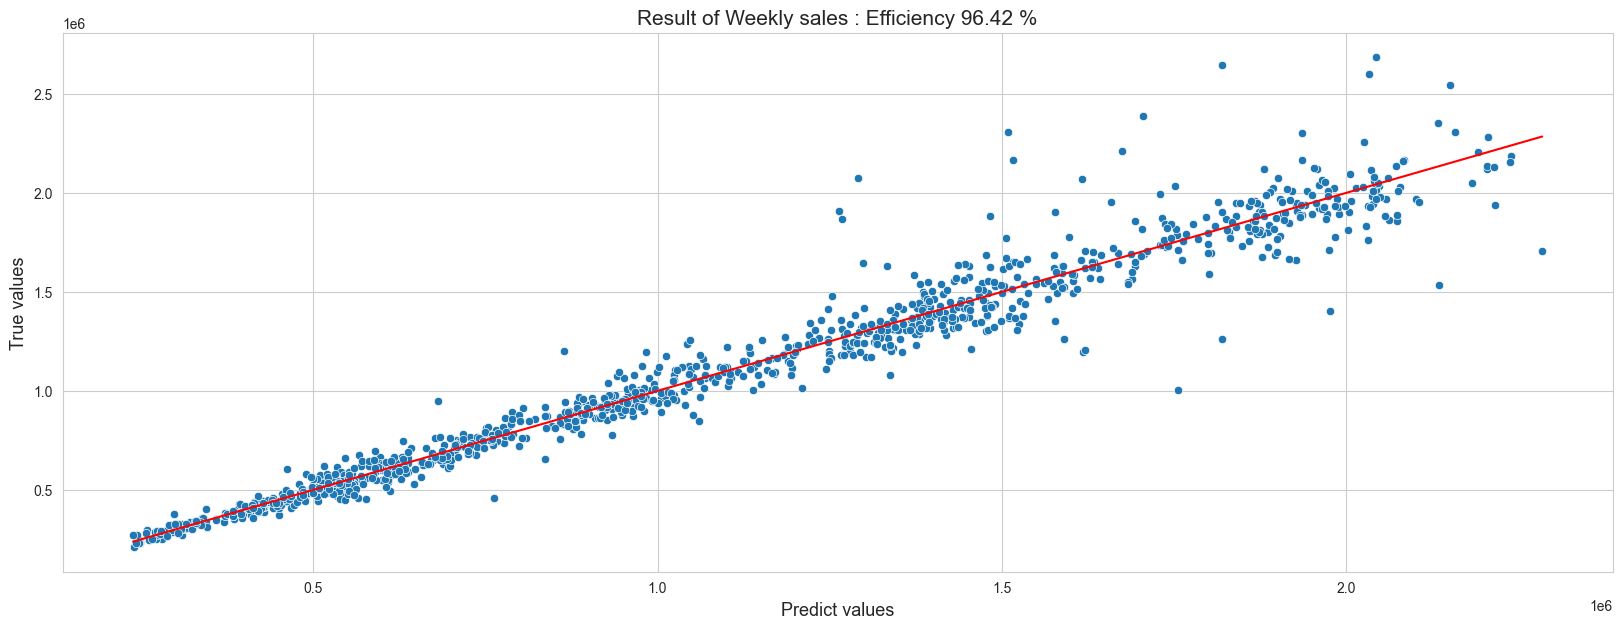

In [ ]:
# Configure the graph display
fig, ax = plt.subplots(figsize=(20,7))
sns.scatterplot(x=y_pred,
                y=y_test,
                ax=ax
                )
sns.lineplot(x=y_pred,
             y=y_pred,
             color='r',
             ax=ax
             )
# Configure the title text
ax.set_title(f"Result of Weekly sales : Efficiency {R2_tune*100:.2f} %", fontsize=15);
ax.set_xlabel("Predict values", fontsize=13)
ax.set_ylabel("True values", fontsize=13);

In [ ]:
y_test.head()

Date
2010-10-29    1802755.11
2012-09-07     663814.18
2011-04-15     607691.36
2010-02-05     652122.44
2010-06-04    2022705.22
Name: Weekly_Sales, dtype: float64